# Mixture Models using PyMC

## Simple Gaussian

Generated 5000 samples using parameters [5. 1.]


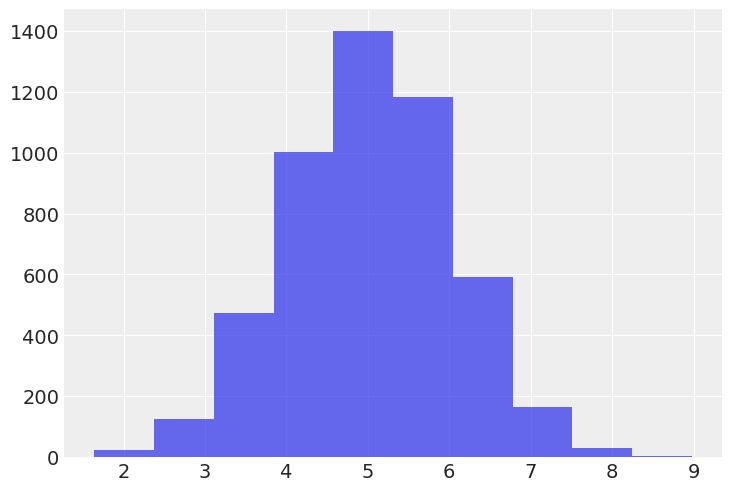

In [83]:
# Create a simple example

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 5000)
#curv.generate_background(xrange, 10.0)

measured = curv.data

#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)


In [84]:
import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal("mu", mu=4, sigma=3)
    sigma = pm.HalfNormal("sigma", sigma=2)
        
    like = pm.Normal("like", mu=mu, sigma=sigma, observed=measured)

# MAP model is "maximum a posteriori", i.e. find the peak in the
# posterior likelihood like you do for MLE.
map_estimate=pm.find_MAP(model=model)
map_estimate

# That is equivalent what EMTK is doing, so far so good.

{'mu': array(5.02424317),
 'sigma_log__': array(0.01797906),
 'sigma': array(1.01814166)}

## Gaussian With Background

Generated 2000 samples using parameters [5. 1.]


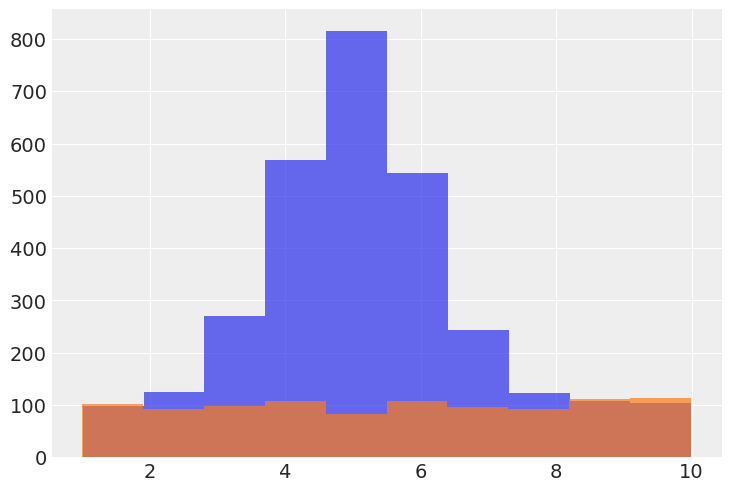

In [85]:
# Create sample measurement and background measurement

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 2000)
#curv.generate_background(xrange, 10.0)

sample_bg = np.random.uniform(xrange[0], xrange[1], 1000)
measured_bg = np.random.uniform(xrange[0], xrange[1], 1000)

measured = curv.data
measured = np.append(measured, sample_bg)
np.random.shuffle(measured)


#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)
bb=ax.hist(measured_bg, alpha=0.7)#, density=True)
xgrid = np.arange(2, 8, 0.5)
#xgrid = hh[1]
xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)


In [86]:
# Now we do the mixture model

import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # mixture model weights
    w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
    # Dirichlet distribution is a multivariate beta distribution,
    # C.F. simple bayesian inference with a beta distribution
    
    # Priors for unknown gaussian model parameters
    mu_par = pm.Normal("mu", mu=4, sigma=3)
    sigma_par = pm.HalfNormal("sigma", sigma=2)
    
    # Components in overall model - simple version because we are 
    # using different component distributions
    components = [
        pm.Uniform.dist(lower=xrange[0], upper=xrange[1]),
        pm.Normal.dist(mu=mu_par, sigma=sigma_par),
    ]
    
    like = pm.Mixture("like", w=w, comp_dists = components, observed=measured)

map_estimate=pm.find_MAP(model=model)
map_estimate
                    

{'weights_simplex__': array([-0.33894137]),
 'mu': array(5.02441957),
 'sigma_log__': array(-0.00662211),
 'weights': array([0.33673402, 0.66326598]),
 'sigma': array(0.99339977)}

**BINGO**

In [87]:
# Now we use MCMC to sample the distributions properly, and obtain a full statistical analysis.

with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'weights'}>,
        <Axes: title={'center': 'weights'}>]], dtype=object)

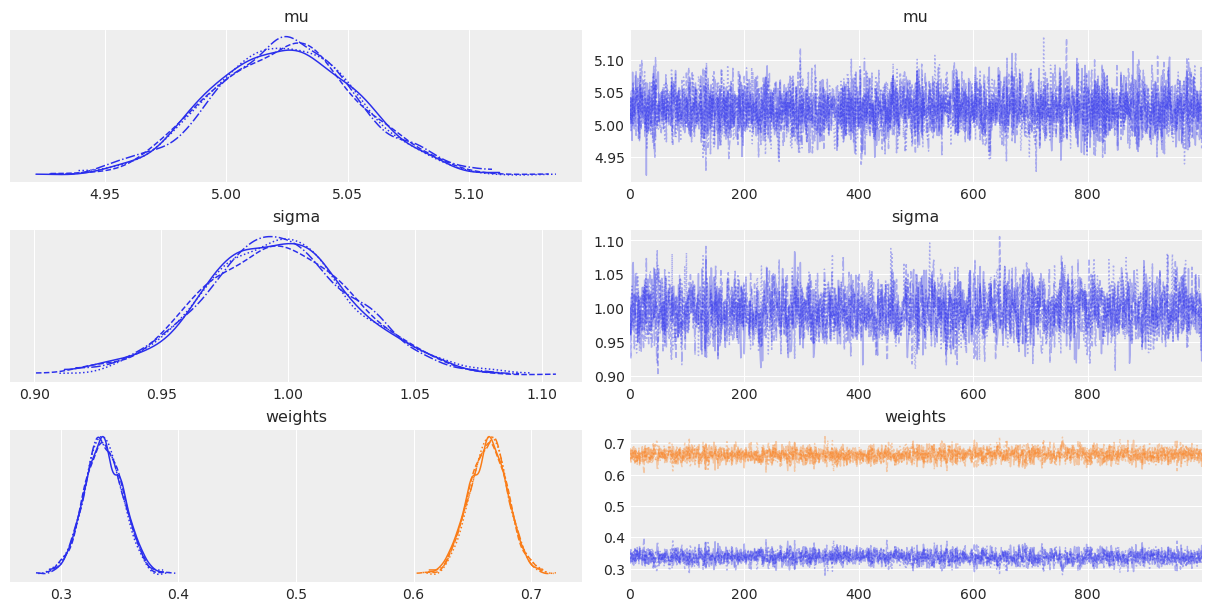

In [88]:
az.plot_trace(idata, var_names=["mu", "sigma", "weights"])

In [89]:
# If we want to do our own statistical analysis on the output, the sample() routine can be called
# with return_inferencedata=False.  This is a much easier object to deal with, to be honest.
with model:
    idata = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [90]:
print(idata.varnames)

['weights_simplex__', 'mu', 'sigma_log__', 'weights', 'sigma']


In [134]:
mu = np.round(np.mean(idata['mu']), decimals = 4)
err_mu = np.round(np.std(idata['mu']), decimals=4)
sigma = np.round(np.mean(idata['sigma']), decimals=4)
err_sigma = np.round(np.std(idata['sigma']), decimals=4)

bg_weight = np.mean(idata['weights'][:,0])
signal_weight = np.mean(idata['weights'][:,1])

print("Loc.  = ", mu, "+/-", err_mu)
print("Sigma = ", sigma, "+/-", err_sigma)
print("Background weight = ", np.round(bg_weight, decimals = 3))
print("Signal weight = ", np.round(signal_weight, decimals = 3))

Loc.  =  5.0249 +/- 0.0287
Sigma =  0.9946 +/- 0.0291
Background weight =  0.337
Signal weight =  0.663


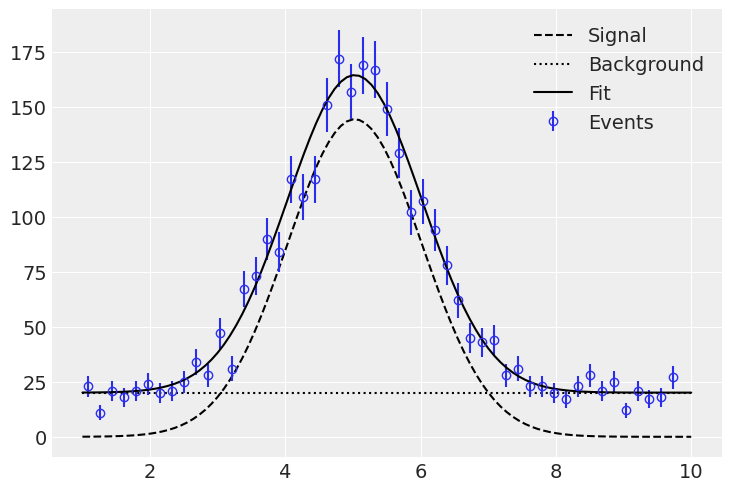

In [126]:

nx = 100.0
nh = 50.0

xi = np.linspace(xrange[0], xrange[1], int(nx))
hbins = np.arange(xrange[0], xrange[1], (xrange[1]-xrange[0])/(nh + 1.0))

# Normalise the signal component
fit_signal = sp.stats.norm.pdf(xi, loc=mu, scale=sigma)
fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

# Normalise the background component
# This next one is brainless but done for the sake of consistency
fit_bg = sp.stats.uniform.pdf(xi, loc=xrange[0], scale=(xrange[1]-xrange[0]))
fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

fit_total = fit_signal + fit_bg

# Get the measured data histogrammed up with error bars
hst = np.histogram(measured, bins=hbins)
rl = np.roll(hbins, -1)
xhist = 0.5*(hbins+rl)
xhist = np.delete(xhist,-1)
yvals = hst[0]
errors= np.sqrt(yvals)

sumhist = np.sum(yvals)

sumfit = np.sum(fit_total)

scale = (nx / nh) * (sumhist / sumfit)

fit_signal = fit_signal * scale
fit_bg = fit_bg * scale
fit_total = fit_total * scale

fig, ax = plt.subplots()
ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
ax.plot(xi, fit_total, color='black', label="Fit")
ax.legend()

# Statistical Comparison to LSE with Noisy Gaussian

In [1]:
import pymc as pm
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

xmin = 0.0
xmax = 10.0


def generate_data(npoints, xmin=1.0, xmax=10.0, mu=5.0, sigma=1.0, sn_ratio = 3.0):
    bgfrac = 1.0 / (sn_ratio + 1.0)
    
    nbg = int(np.floor(npoints * bgfrac))
    nsig = npoints - nbg
    
    signal = sp.stats.norm.rvs(size=nsig, loc=mu, scale=sigma)
    background = sp.stats.uniform.rvs(size=nbg, loc=xmin, scale=(xmax+xmin))
    result = np.concatenate((signal, background))
    np.random.shuffle(result)
    
    return result



def bayesian_MAP_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        mu_par = pm.Normal("mu", mu=4, sigma=4)
        sigma_par = pm.HalfNormal("sigma", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.Normal.dist(mu=mu_par, sigma=sigma_par),
            pm.Uniform.dist(lower=xmin, upper=xmax),            
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        map_estimate=pm.find_MAP(model=model, progressbar=False, return_raw=True)
        
        # Extracting the sigma and variance is a bit of a faff here
        # PyMC transforms bounded variables so we have to untransform them
        # In this case, it's working with log-sigma
        logsigma_est = map_estimate[0]['sigma_log__']
        sigma_est = np.exp(logsigma_est)
        
        # Since this is basically equivalent to maximum likelihood,
        # the variance of log-sigma is the sqrt of the third element of the 
        # diagonal of the inverse hessian matrix, which scipy conveniently provides
        # for good reason!
        variances = np.sqrt(np.diag(map_estimate[1].hess_inv.todense()))
        logsigma_variance = variances[2]
        logsigma_plus_logvariance = logsigma_est + logsigma_variance
        logsigma_minus_logvariance = logsigma_est - logsigma_variance
        sigmaplus = np.exp(logsigma_plus_logvariance)
        sigmaminus = np.exp(logsigma_minus_logvariance)
        
        err1 = sigmaplus - sigma_est
        err2 = sigma_est - sigmaminus
        err_sigma = 0.5 * (err1 + err2) # statistical resampling finds this is 2x too large
        # so will take the smaller one
        
        err_sigma = np.amin(np.array([err1, err2]))
                                
        mu_est = map_estimate[0]['mu']
        err_mu = variances[1]
        signal_weight = map_estimate[0]['weights'][0]
        bg_weight = map_estimate[0]['weights'][1]

        if verbose:
            print("Data size:", npts)
            print("Loc.  = ", mu_est, "+/-", err_mu)
            print("Sigma = ", sigma_est, "+/-", err_sigma)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.norm.pdf(xi, loc=mu_est, scale=sigma_est)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.legend()

        return sigma_est, err_sigma




def bayesian_MCMC_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        mu_par = pm.Normal("mu", mu=4, sigma=4)
        sigma_par = pm.HalfNormal("sigma", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.Uniform.dist(lower=xmin, upper=xmax),
            pm.Normal.dist(mu=mu_par, sigma=sigma_par),
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        idata = pm.sample(return_inferencedata=False, progressbar=False)
        
        mu = np.round(np.mean(idata['mu']), decimals = 4)
        err_mu = np.round(np.std(idata['mu']), decimals=4)
        sigma = np.round(np.mean(idata['sigma']), decimals=4)
        err_sigma = np.round(np.std(idata['sigma']), decimals=4)

        bg_weight = np.mean(idata['weights'][:,0])
        signal_weight = np.mean(idata['weights'][:,1])

        if verbose:
            print("Data size:", npts)
            print("Loc.  = ", mu, "+/-", err_mu)
            print("Sigma = ", sigma, "+/-", err_sigma)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.norm.pdf(xi, loc=mu, scale=sigma)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.legend()

        return sigma, err_sigma
    
    
    



def gaussian_ls_func(x, amp, mu, sigma, bg):
    first = amp / (sigma * np.sqrt(2.0 * np.pi))
    
    second = np.exp(-0.5 * ((x-mu)/sigma)**2.0)
    
    return first * second + bg

def ls_fit(spectrum, xmin=0.0, xmax=10.0, plot=False, verbose=True):

    mu_guess = np.mean(spectrum)   # actually MLE so should be close
    sigma_guess = 0.5 * np.std(spectrum) # likewise

    gmodel = Model(gaussian_ls_func)
    
    nx = 100.0
    nh = 50.0

    xi = np.linspace(xmin, xmax, int(nx))
    hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

    hst = np.histogram(spectrum, bins=hbins)
    rl = np.roll(hbins, -1)
    xhist = 0.5*(hbins+rl)
    xhist = np.delete(xhist,-1)
    yvals = hst[0]
    errors= np.sqrt(yvals)
    
    bg_guess = yvals[0]
    amp_guess = np.amax(yvals)
    
    result = gmodel.fit(yvals, x=xhist, amp=amp_guess, mu=mu_guess, sigma=sigma_guess, bg=bg_guess)
    
    if verbose:
        print(result.fit_report())
    
    if plot:
        fig, ax = plt.subplots()
        ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
        ax.plot(xhist, result.init_fit, '--', color='black', label="LSE initial")
        ax.plot(xhist, result.best_fit, color='black', label="LSE fit")
        ax.legend()
    
    width = result.params["sigma"].value
    variance = result.params["sigma"].stderr
        
    return width, variance    

    

    
    

            
nspectra = 15
sizes = np.round(np.logspace(1, 6, num=nspectra))
print(sizes)

sizes_mcmc = sizes[sizes < 20000.0]
print(sizes_mcmc)

spectra = []
bayesian_widths = []
bayesian_variances = []
least_squares_widths = []
least_squares_variances = []

test_spectrum = generate_data(3000, xmin=xmin, xmax=xmax, sn_ratio=3.0)

for i in range(nspectra):
    spectrum = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
    spectra.append(spectrum)



[1.00000e+01 2.30000e+01 5.20000e+01 1.18000e+02 2.68000e+02 6.11000e+02
 1.38900e+03 3.16200e+03 7.19700e+03 1.63790e+04 3.72760e+04 8.48340e+04
 1.93070e+05 4.39397e+05 1.00000e+06]
[1.0000e+01 2.3000e+01 5.2000e+01 1.1800e+02 2.6800e+02 6.1100e+02
 1.3890e+03 3.1620e+03 7.1970e+03 1.6379e+04]


Data size: 3000
Loc.  =  4.9746658519944384 +/- 0.21748230083241643
Sigma =  1.0095712209370025 +/- 0.08158621666940125
Background weight =  0.242
Signal weight =  0.758


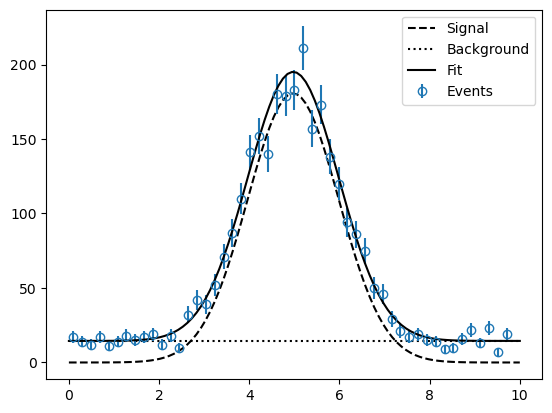

In [70]:
# Before we waste time looping, make sure that the test works correctly for bayesian MAP
obj=bayesian_MAP_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 3000
Loc.  =  4.9748 +/- 0.0255
Sigma =  1.0102 +/- 0.0225
Background weight =  0.243
Signal weight =  0.757


(1.0102, 0.0225)

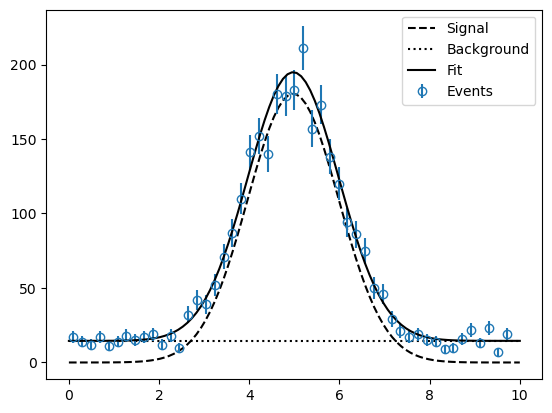

In [71]:
# Before we waste time looping, make sure that the test works correctly for bayesian MCMC
bayesian_MCMC_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

[[Model]]
    Model(gaussian_ls_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 50
    # variables        = 4
    chi-square         = 2969.20114
    reduced chi-square = 64.5478508
    Akaike info crit   = 212.201261
    Bayesian info crit = 219.849353
    R-squared          = 0.98353317
[[Variables]]
    amp:    449.911846 +/- 12.5364392 (2.79%) (init = 211)
    mu:     4.97741215 +/- 0.02202000 (0.44%) (init = 4.979772)
    sigma:  1.03034059 +/- 0.02625971 (2.55%) (init = 0.8409462)
    bg:     13.8290840 +/- 1.71054499 (12.37%) (init = 17)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, bg)    = -0.7475
    C(amp, sigma) = +0.7288
    C(sigma, bg)  = -0.5448


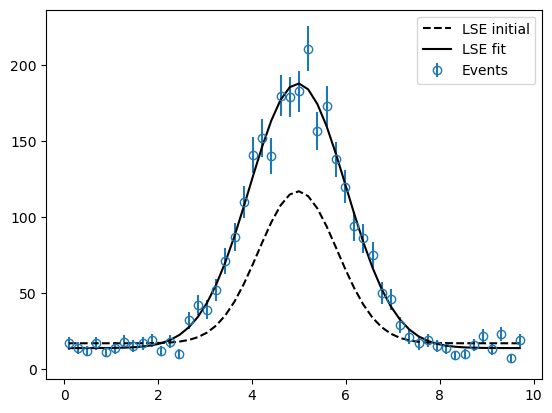

In [72]:
# Before we waste time looping, make sure that the test works correctly for least squares
test_result = ls_fit(test_spectrum, plot=True, verbose=True, xmin=xmin, xmax=xmax)

In [21]:
# Fit all the data runs with least squares regression
least_squares_widths=[]
least_squares_variances=[]

for i in range(nspectra):
    width, variance = ls_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False, verbose=False)
    variance_accum = [width]
    
    for j in range(10):
        resample = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
        width, variance = ls_fit(resample, xmin=xmin, xmax=xmax, plot=False, verbose=False)
        variance_accum.append(width)
    
    resampled_variance = np.std(np.asarray(variance_accum))
    print("Theoretical variance", variance)
    print("Resampled variance", resampled_variance)
    least_squares_widths.append(width)
    least_squares_variances.append(resampled_variance)

Theoretical variance 0.0940233977759506
Resampled variance 0.40582624317031435
Theoretical variance 0.2792382173196568
Resampled variance 0.3609428313468041
Theoretical variance 0.13165952960631055
Resampled variance 0.28234464888509225
Theoretical variance 0.10948878751280482
Resampled variance 0.1064611357853613
Theoretical variance 0.055975072060086534
Resampled variance 0.11857817764476232
Theoretical variance 0.04490861095570209
Resampled variance 0.06910320587924466
Theoretical variance 0.0321404031757894
Resampled variance 0.04281706201156509
Theoretical variance 0.024075983323195
Resampled variance 0.022563180447798224
Theoretical variance 0.01648898388395268
Resampled variance 0.016504957084469644
Theoretical variance 0.00822706491278146
Resampled variance 0.015123218260638028
Theoretical variance 0.007447362229339619
Resampled variance 0.009729443369481859
Theoretical variance 0.004636605491487684
Resampled variance 0.004980212067971053
Theoretical variance 0.0031027931713709

In [24]:
# Fit all the data runs with bayesian MAP

from tqdm.notebook import tqdm
import time
from joblib import Parallel, delayed
from joblib import cpu_count

bayesian_MAP_widths = []
bayesian_MAP_variances = []

def do_resample(size):
    resampled = generate_data(size, xmin=xmin, xmax=xmax, sn_ratio=3.0)
    width, variance = bayesian_MAP_fit(resampled, xmin=xmin, xmax=xmax, plot=False, verbose=False)
    return width

for i in tqdm(range(nspectra)):
    width, variance = bayesian_MAP_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False)
    size = int(sizes[i])
    #variance_accum = [0.0] * 10
    #variance_accum[0] = width
    
    #for j in range(1,10):
    #        resample = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
    #        width, variance = bayesian_MAP_fit(resample, xmin=xmin, xmax=xmax, plot=False, verbose=False)
    #        variance_accum[j]=width
   
    parallel = Parallel(n_jobs=cpu_count())
    variance_accum = parallel(delayed(do_resample)(size) for j in range(1,8))
    variance_accum.append(width)

    resampled_variance = np.std(np.asarray(variance_accum))
    print("Theoretical variance", variance)
    print("Resampled variance", resampled_variance)
    
    bayesian_MAP_widths.append(width)
    bayesian_MAP_variances.append(resampled_variance)

  0%|          | 0/15 [00:00<?, ?it/s]

Data size: 10
Loc.  =  5.042600791330007 +/- 0.3188502407710442
Sigma =  0.791974929735022 +/- 0.1936617564776818
Background weight =  0.181
Signal weight =  0.819
Theoretical variance 0.1936617564776818
Resampled variance 0.27375230078910073
Data size: 23
Loc.  =  4.702553928524214 +/- 0.11316296156451768
Sigma =  0.3665710418886783 +/- 0.06850095805680118
Background weight =  0.324
Signal weight =  0.676
Theoretical variance 0.06850095805680118
Resampled variance 0.36806758722698074
Data size: 52
Loc.  =  5.10062310361159 +/- 0.20741067174837532
Sigma =  0.9654833690276703 +/- 0.23242010462508422
Background weight =  0.276
Signal weight =  0.724
Theoretical variance 0.23242010462508422
Resampled variance 0.1702361061009346
Data size: 118
Loc.  =  4.901412183594578 +/- 0.16591534447726636
Sigma =  1.0833271009302694 +/- 0.14707262812573707
Background weight =  0.2
Signal weight =  0.8
Theoretical variance 0.14707262812573707
Resampled variance 0.12978519665670696
Data size: 268
Loc.  

In [22]:
# Fit all the data runs with bayesian MCMC
bayesian_MCMC_widths = []
bayesian_MCMC_variances = []

nspectra_mcmc = sizes_mcmc.size

for i in tqdm(range(nspectra_mcmc)):
    width, variance = bayesian_MCMC_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False)
    bayesian_MCMC_widths.append(width)
    bayesian_MCMC_variances.append(variance)

  0%|          | 0/10 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Data size: 10
Loc.  =  5.0602 +/- 0.8293
Sigma =  1.1515 +/- 0.7416
Background weight =  0.33
Signal weight =  0.67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 23
Loc.  =  4.7473 +/- 0.179
Sigma =  0.5071 +/- 0.231
Background weight =  0.323
Signal weight =  0.677


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 52
Loc.  =  5.1337 +/- 0.2282
Sigma =  1.071 +/- 0.2229
Background weight =  0.283
Signal weight =  0.717


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 118
Loc.  =  4.9108 +/- 0.1374
Sigma =  1.1025 +/- 0.1229
Background weight =  0.215
Signal weight =  0.785


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 268
Loc.  =  5.0314 +/- 0.0842
Sigma =  0.988 +/- 0.0819
Background weight =  0.266
Signal weight =  0.734


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 611
Loc.  =  4.9249 +/- 0.0559
Sigma =  0.9644 +/- 0.0472
Background weight =  0.269
Signal weight =  0.731


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 1389
Loc.  =  4.9749 +/- 0.0372
Sigma =  0.9766 +/- 0.0349
Background weight =  0.272
Signal weight =  0.728


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 3162
Loc.  =  4.9842 +/- 0.0248
Sigma =  1.0108 +/- 0.0229
Background weight =  0.26
Signal weight =  0.74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Data size: 7197
Loc.  =  4.983 +/- 0.0157
Sigma =  1.0 +/- 0.0154
Background weight =  0.249
Signal weight =  0.751


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Data size: 16379
Loc.  =  4.9851 +/- 0.0109
Sigma =  1.0018 +/- 0.0105
Background weight =  0.252
Signal weight =  0.748


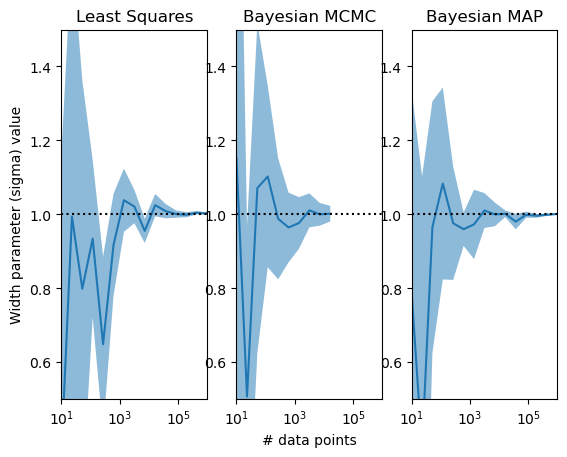

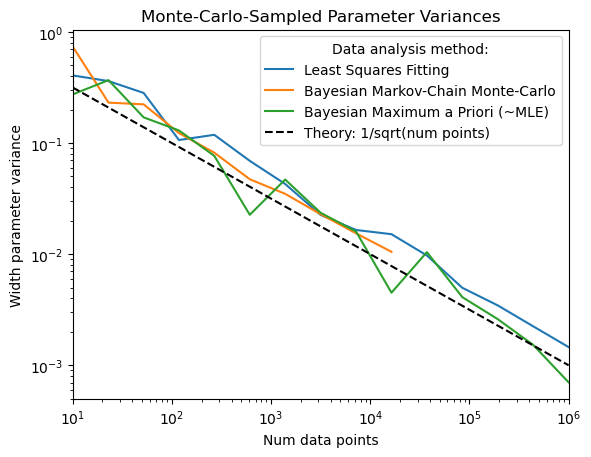

## Lorentzian SANS With Flat Background

In [3]:
# Optional tests

# Test that JAX sees apple METAL gpu and not cpu
from jax.lib import xla_bridge
platform = xla_bridge.get_backend().platform
assert platform != 'cpu', f"gpu not initialised in JAX, platform is: {platform}"

In [5]:
import pymc as pm
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

xmin = 0.001
xmax=0.1


def generate_data(npoints, xmin=0.001, xmax=0.1, centre=0.0, kappa=0.01, sn_ratio = 10.0):
    bgfrac = 1.0 / (sn_ratio + 1.0)
    
    nbg = int(np.floor(npoints * bgfrac))
    nsig = npoints - nbg
    
    signal = sp.stats.halfcauchy.rvs(size=nsig, loc=0.0, scale=kappa)
    signal = np.abs(signal)
    background = sp.stats.uniform.rvs(size=nbg, loc=xmin, scale=(xmax+xmin))
    result = np.concatenate((signal, background))
    np.random.shuffle(result)
    
    return result


def data_compare(data1, data2, xmin, xmax):
    
    hbins = np.arange(xmin, xmax, (xmax-xmin)/(50 + 1.0))
    
    # Get the measured data histogrammed up with error bars
    hst1 = np.histogram(data1, bins=hbins)
    hst2 = np.histogram(data2, bins=hbins)
    
    rl = np.roll(hbins, -1)
    xhist = 0.5*(hbins+rl)
    xhist = np.delete(xhist,-1)
    y1 = hst1[0]
    err1= np.sqrt(y1)
    y2 = hst2[0]
    err2= np.sqrt(y2)

    fig, ax = plt.subplots()
    ax.errorbar(xhist, y1, err1, fmt='o', mfc='none', label="Data 1")
    ax.errorbar(xhist, y2, err2, fmt='o', mfc='none', label="Data 2")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    


def bayesian_MAP_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        #mu_par = pm.Normal("mu", mu=4, sigma=4)
        kappa_par = pm.HalfNormal("kappa", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.HalfCauchy.dist(beta=kappa_par),
            pm.Uniform.dist(lower=xmin, upper=xmax),            
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        map_estimate=pm.find_MAP(model=model, progressbar=False, return_raw=True)
        
        # Extracting the sigma and variance is a bit of a faff here
        # PyMC transforms bounded variables so we have to untransform them
        # In this case, it's working with log-sigma
        logkappa_est = map_estimate[0]['kappa_log__']
        kappa_est = np.exp(logkappa_est)
        
        # Since this is basically equivalent to maximum likelihood,
        # the variance of log-sigma is the sqrt of the third element of the 
        # diagonal of the inverse hessian matrix, which scipy conveniently provides
        # for good reason!
        variances = np.sqrt(np.diag(map_estimate[1].hess_inv.todense()))
        logkappa_variance = variances[1]
        logkappa_plus_logvariance = logkappa_est + logkappa_variance
        logkappa_minus_logvariance = logkappa_est - logkappa_variance
        kappaplus = np.exp(logkappa_plus_logvariance)
        kappaminus = np.exp(logkappa_minus_logvariance)
        
        err1 = kappaplus - kappa_est
        err2 = kappa_est - kappaminus
        err_kappa = 0.5 * (err1 + err2) # statistical resampling finds this is 2x too large
        # so will take the smaller one
        
        err_kappa = np.amin(np.array([err1, err2]))
        
        signal_weight = map_estimate[0]['weights'][0]
        bg_weight = map_estimate[0]['weights'][1]

        if verbose:
            print("Data size:", npts)
            print("Kappa = ", kappa_est, "+/-", err_kappa)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.halfcauchy.pdf(xi, scale=kappa_est)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.legend()

        return kappa_est, err_kappa




def bayesian_MCMC_fit(spectrum, xmin, xmax, plot=False, verbose=True, use_GPU=False):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        kappa_par = pm.HalfNormal("kappa", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.Uniform.dist(lower=xmin, upper=xmax),
            pm.HalfCauchy.dist(beta=kappa_par),
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        if use_GPU:
            idata = pm.sample(nuts_sampler="numpyro", return_inferencedata=False, progressbar=False)
        else:
            idata = pm.sample(return_inferencedata=False, progressbar=False, cores=4)
        
        kappa = np.round(np.mean(idata['kappa']), decimals=4)
        err_kappa = np.round(np.std(idata['kappa']), decimals=4)

        bg_weight = np.mean(idata['weights'][:,0])
        signal_weight = np.mean(idata['weights'][:,1])

        if verbose:
            print("Data size:", npts)
            print("Kappa = ", kappa, "+/-", err_kappa)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.halfcauchy.pdf(xi, loc=0.0, scale=kappa)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.legend()

        return kappa, err_kappa
    
    
    



def halfcauchy_ls_func(x, amp, kappa, bg):
    sig = amp * sp.stats.halfcauchy.pdf(x, loc=0.0, scale=kappa) 
    return sig + bg

def ls_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    kappa_guess = 0.1 * xmax

    cmodel = Model(halfcauchy_ls_func)

    nx = 100.0
    nh = 50.0

    xi = np.linspace(xmin, xmax, int(nx))
    hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

    hst = np.histogram(spectrum, bins=hbins)
    rl = np.roll(hbins, -1)
    xhist = 0.5*(hbins+rl)
    xhist = np.delete(xhist,-1)
    yvals = hst[0]
    errors= np.sqrt(yvals)
    
    bg_guess = yvals[-1]
    amp_guess = yvals[0]*xhist[0]
    
    params = cmodel.make_params(amp=dict(value=amp_guess, min=0.0),\
                       kappa=dict(value=kappa_guess, min=xmin),\
                       bg=dict(value=bg_guess, min=0.0))
    
    result = cmodel.fit(yvals, params, x=xhist)
    
    if verbose:
        print(result.fit_report())
    
    if plot:
        
    
        fig, ax = plt.subplots()
        ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
        ax.plot(xhist, result.init_fit, '--', color='black', label="LSE initial")
        ax.plot(xhist, result.best_fit, color='black', label="LSE fit")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    
    width = result.params["kappa"].value
    variance = result.params["kappa"].stderr
        
    return width, variance    

    

    
    

            
nspectra = 15
sizes = np.round(np.logspace(3, 6, num=nspectra))
sizes = np.flip(sizes)
print(sizes)

mcmc_capable = sizes < 100000.0

sizes_mcmc = sizes[mcmc_capable]
print(sizes_mcmc)

spectra = []
bayesian_widths = []
bayesian_variances = []
least_squares_widths = []
least_squares_variances = []
spectra_mcmc = []

test_spectrum = generate_data(20000, xmin=xmin, xmax=xmax)
big_test_spectrum = generate_data(1000000, xmin=xmin, xmax=xmax)

for i in range(nspectra):
    spectrum = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax)
    spectra.append(spectrum)
    if sizes[i] < 100000.0 :
        spectra_mcmc.append(spectrum)



[1000000.  610540.  372759.  227585.  138950.   84834.   51795.   31623.
   19307.   11788.    7197.    4394.    2683.    1638.    1000.]
[84834. 51795. 31623. 19307. 11788.  7197.  4394.  2683.  1638.  1000.]


Text(0.5, 0, 'Num data points (events)')

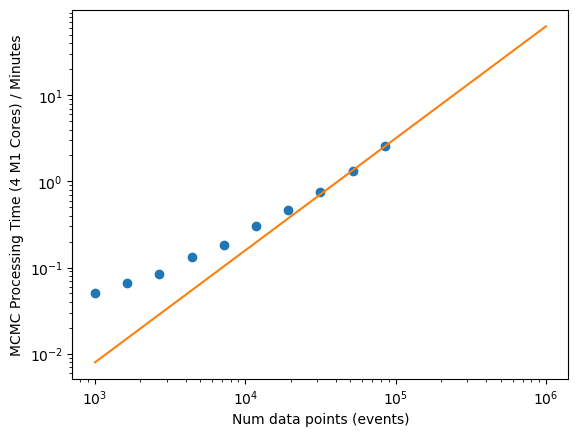

In [89]:
sample_times = np.array([3, 4, 5, 8, 11, 18, 28, 45, 80, 154])
extrap = 1.0E-06 * sizes**1.3
cutsizes = sizes[sizes < 90000.0]
fig,ax = plt.subplots()
ax.plot(cutsizes, sample_times/60.0, linestyle='None', marker='o')
ax.plot(sizes, extrap)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('MCMC Processing Time (4 M1 Cores) / Minutes')
ax.set_xlabel('Num data points (events)')

Data size: 1000000
Kappa =  0.010075781209587372 +/- 1.7666859393397974e-05
Background weight =  0.087
Signal weight =  0.913
Data size: 20000
Kappa =  0.010199920817106217 +/- 0.0001033318537639813
Background weight =  0.083
Signal weight =  0.917


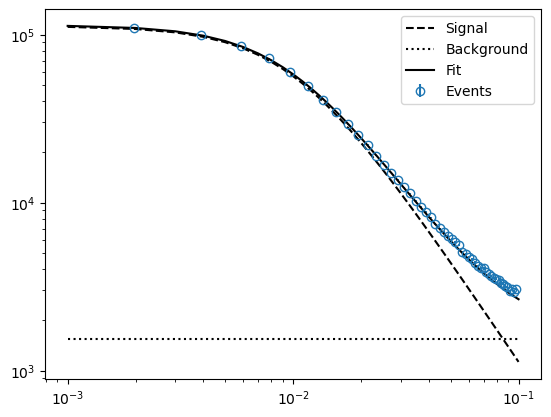

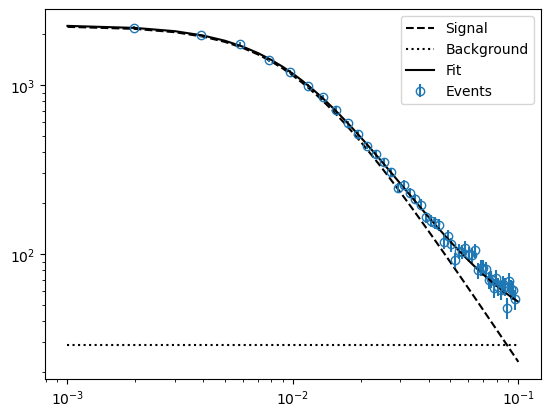

In [6]:
# Before we waste time looping, make sure that the test works correctly for bayesian MAP
big_test_spectrum = generate_data(1000000, xmin=xmin, xmax=xmax)
obj=bayesian_MAP_fit(big_test_spectrum, plot=True, xmin=xmin, xmax=xmax)
obj=bayesian_MAP_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

[[Model]]
    Model(halfcauchy_ls_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 50
    # variables        = 3
    chi-square         = 5577.78181
    reduced chi-square = 118.676209
    Akaike info crit   = 241.726172
    Bayesian info crit = 247.462241
    R-squared          = 0.99956410
[[Variables]]
    amp:    35.6474511 +/- 0.17171451 (0.48%) (init = 4.299824)
    kappa:  0.01017045 +/- 6.3254e-05 (0.62%) (init = 0.01)
    bg:     32.1522916 +/- 2.17633294 (6.77%) (init = 54)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, kappa) = +0.7747
    C(amp, bg)    = -0.7063
    C(kappa, bg)  = -0.5460


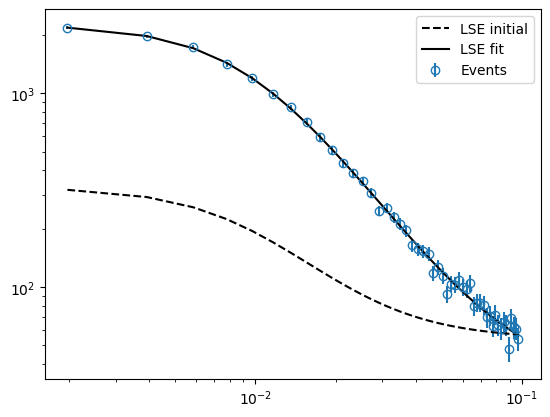

In [7]:
# Before we waste time looping, make sure that the test works correctly for least squares
test_result = ls_fit(test_spectrum, plot=True, verbose=True, xmin=xmin, xmax=xmax)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Data size: 20000
Kappa =  0.0102 +/- 0.0001
Background weight =  0.083
Signal weight =  0.917


(0.0102, 0.0001)

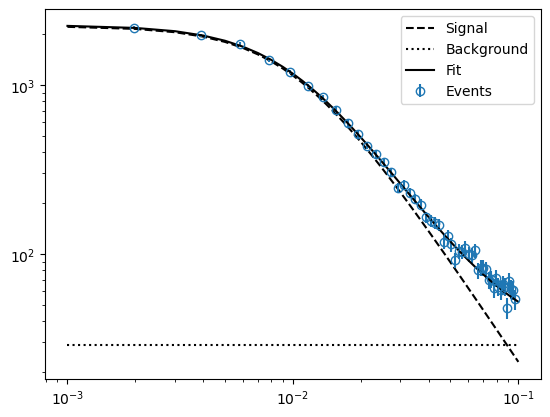

In [8]:
# Before we waste time looping, make sure that the test works correctly for bayesian MCMC
bayesian_MCMC_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

In [9]:
# Fit all the data runs with least squares regression
least_squares_widths=[]
least_squares_variances=[]

for i in range(nspectra):
    width, variance = ls_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False, verbose=False)
    variance_accum = [width]
    rsize = int(sizes[i])
    for j in range(1,8):
        resampled = generate_data(rsize, xmin=xmin, xmax=xmax)
        width, variance = ls_fit(resampled, xmin=xmin, xmax=xmax, plot=False, verbose=False)
        variance_accum.append(width)
    
    resampled_variance = np.std(np.asarray(variance_accum))
    print("Theoretical variance", variance)
    print("Resampled variance", resampled_variance)
    least_squares_widths.append(width)
    least_squares_variances.append(resampled_variance)

Theoretical variance 1.2228955341784606e-05
Resampled variance 1.8094162110589157e-05
Theoretical variance 1.4436233773068747e-05
Resampled variance 3.3730138863718325e-05
Theoretical variance 2.4527196384605542e-05
Resampled variance 4.182682477922831e-05
Theoretical variance 2.7180098822211577e-05
Resampled variance 6.294057339249726e-05
Theoretical variance 3.290282380572283e-05
Resampled variance 6.189636006444766e-05
Theoretical variance 5.450241575739103e-05
Resampled variance 7.723161277694329e-05
Theoretical variance 5.207824844121879e-05
Resampled variance 0.0001097872107257046
Theoretical variance 6.451883114094271e-05
Resampled variance 9.12950718635003e-05
Theoretical variance 0.00012981435885204372
Resampled variance 0.00025497944386635026
Theoretical variance 0.00011481387093579022
Resampled variance 0.0002878482374940279
Theoretical variance 0.00026522430153531326
Resampled variance 0.00037600385579994585
Theoretical variance 0.00019173392863714838
Resampled variance 0.0

In [129]:
# Fit all the data runs with bayesian MAP

from tqdm.notebook import tqdm
import time
from joblib import Parallel, delayed
from joblib import cpu_count

bayesian_MAP_widths = []
bayesian_MAP_variances = []

def do_resample(size):
    resampled = generate_data(size, xmin=xmin, xmax=xmax)
    width, variance = bayesian_MAP_fit(resampled, xmin=xmin, xmax=xmax, plot=False, verbose=False)
    return width

single_thread = True

for i in tqdm(range(nspectra)):
    # the first point:
    width, variance = bayesian_MAP_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False)
    size = int(sizes[i])
    
    if single_thread:
        variance_accum = [width]
        
        for j in range(1,8):
                resample = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax)
                width, variance = bayesian_MAP_fit(resample, xmin=xmin, xmax=xmax, plot=False, verbose=False)
                variance_accum.append(width)
   
    else:
        variance_accum = [0.0] * 8
        variance_accum[0] = width
        parallel = Parallel(n_jobs=cpu_count())
        variance_accum = parallel(delayed(do_resample)(size) for j in range(1,8))
        variance_accum.append(width) # Add the first point above to the parallel points
            
    resampled_variance = np.std(np.asarray(variance_accum))
    print("Theoretical variance", variance)
    print("Resampled variance", resampled_variance)
    
    bayesian_MAP_widths.append(width)
    bayesian_MAP_variances.append(resampled_variance)

  0%|          | 0/15 [00:00<?, ?it/s]

Data size: 1000000
Kappa =  0.01146110117166864 +/- 1.652473094714002e-05
Background weight =  0.0
Signal weight =  1.0
Theoretical variance 1.6498276476779178e-05
Resampled variance 0.0006801165200216233
Data size: 610540
Kappa =  0.011465962746950165 +/- 2.1159401926923796e-05
Background weight =  0.0
Signal weight =  1.0
Theoretical variance 2.1200222294147364e-05
Resampled variance 0.000707599079931464
Data size: 372759
Kappa =  0.011484404158887624 +/- 2.709909499488787e-05
Background weight =  0.0
Signal weight =  1.0
Theoretical variance 4.785251241220742e-05
Resampled variance 0.0006783788703321467
Data size: 227585
Kappa =  0.01145795740296554 +/- 3.458834704235872e-05
Background weight =  0.0
Signal weight =  1.0
Theoretical variance 3.07214765458419e-05
Resampled variance 0.0006061134802048925
Data size: 138950
Kappa =  0.01143500746636367 +/- 4.415701233567021e-05
Background weight =  0.0
Signal weight =  1.0
Theoretical variance 3.626097195812139e-05
Resampled variance 0.0

KeyboardInterrupt: 

In [11]:
# Fit all the data runs with bayesian MCMC
bayesian_MCMC_widths = []
bayesian_MCMC_variances = []

from tqdm.notebook import tqdm
import time

nspectra_mcmc = sizes_mcmc.size

for i in tqdm(range(nspectra_mcmc)):
    data_size = spectra_mcmc[i].size
    print("MCMC on", data_size, "points")
    width, variance = bayesian_MCMC_fit(spectra_mcmc[i], xmin=xmin, xmax=xmax, plot=False)
    bayesian_MCMC_widths.append(width)
    bayesian_MCMC_variances.append(variance)

  0%|          | 0/10 [00:00<?, ?it/s]

MCMC on 84834 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.


Data size: 84834
Kappa =  0.0101 +/- 0.0001
Background weight =  0.088
Signal weight =  0.912
MCMC on 51795 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


Data size: 51795
Kappa =  0.01 +/- 0.0001
Background weight =  0.088
Signal weight =  0.912
MCMC on 31623 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Data size: 31623
Kappa =  0.0101 +/- 0.0001
Background weight =  0.084
Signal weight =  0.916
MCMC on 19307 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Data size: 19307
Kappa =  0.0101 +/- 0.0001
Background weight =  0.087
Signal weight =  0.913
MCMC on 11788 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Data size: 11788
Kappa =  0.0098 +/- 0.0002
Background weight =  0.097
Signal weight =  0.903
MCMC on 7197 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Data size: 7197
Kappa =  0.0102 +/- 0.0002
Background weight =  0.083
Signal weight =  0.917
MCMC on 4394 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Data size: 4394
Kappa =  0.0098 +/- 0.0003
Background weight =  0.084
Signal weight =  0.916
MCMC on 2683 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Data size: 2683
Kappa =  0.0099 +/- 0.0003
Background weight =  0.096
Signal weight =  0.904
MCMC on 1638 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data size: 1638
Kappa =  0.0095 +/- 0.0004
Background weight =  0.1
Signal weight =  0.9
MCMC on 1000 points


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, kappa]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data size: 1000
Kappa =  0.0107 +/- 0.0006
Background weight =  0.075
Signal weight =  0.925


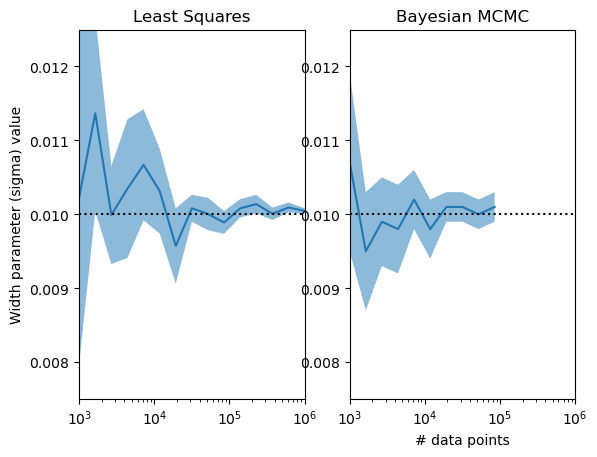

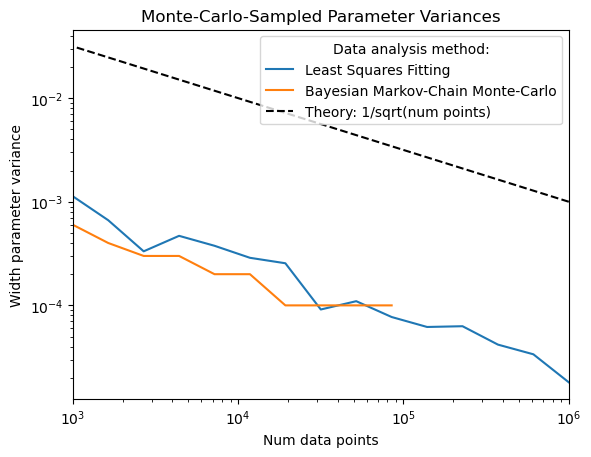

In [12]:
# Compare the fitting methods

fig,ax=plt.subplots(1,2)

# 2 sigma (95%) bands

ls_lower = np.asarray(least_squares_widths) - 2.0 * np.asarray(least_squares_variances)
ls_upper = np.asarray(least_squares_widths) + 2.0 * np.asarray(least_squares_variances)

by_lower = np.asarray(bayesian_MCMC_widths) - 2.0 * np.asarray(bayesian_MCMC_variances)
by_upper = np.asarray(bayesian_MCMC_widths) + 2.0 * np.asarray(bayesian_MCMC_variances)

#map_lower = np.asarray(bayesian_MAP_widths) - 2.0 * np.asarray(bayesian_MAP_variances)
#map_upper = np.asarray(bayesian_MAP_widths) + 2.0 * np.asarray(bayesian_MAP_variances)

pmin = 0.0075
pmax = 0.0125

correct = 0.010

ax[0].plot(sizes, least_squares_widths)
ax[0].fill_between(sizes, y1=ls_lower, y2=ls_upper, alpha=0.5) 
ax[1].plot(sizes_mcmc, bayesian_MCMC_widths)
ax[1].fill_between(sizes_mcmc, y1=by_lower, y2=by_upper, alpha = 0.5)
#ax[2].plot(sizes, bayesian_MAP_widths)
#ax[2].fill_between(sizes, y1=map_lower, y2=map_upper, alpha=0.5)

ax[0].set_xscale('log')
ax[0].set_ylim(pmin, pmax)
ax[0].set_xlim(np.amin(sizes), np.amax(sizes))
ax[0].set_title('Least Squares')
ax[0].set_ylabel('Width parameter (sigma) value')
ax[0].axhline(y=correct, color='black', linestyle='dotted')

ax[1].set_xscale('log')
ax[1].set_ylim(pmin, pmax)
ax[1].set_xlim(np.amin(sizes), np.amax(sizes))
ax[1].set_title('Bayesian MCMC')
ax[1].axhline(y=correct, color='black', linestyle='dotted')
ax[1].set_xlabel('# data points')

#ax[2].set_title('Bayesian MAP')
#ax[2].set_xscale('log')
#ax[2].set_ylim(pmin, pmax)
#ax[2].set_xlim(np.amin(sizes), np.amax(sizes))
#ax[2].axhline(y=correct, color='black', linestyle='dotted')

trend = 1.0 / sizes**0.5

fig, ax = plt.subplots()
ax.plot(sizes, least_squares_variances, label='Least Squares Fitting')
ax.plot(sizes_mcmc, bayesian_MCMC_variances, label='Bayesian Markov-Chain Monte-Carlo')
#ax.plot(sizes, bayesian_MAP_variances, label='Bayesian Maximum a Posteriori (~MLE)')
ax.plot(sizes, trend, color='black', linestyle='dashed', label='Theory: 1/sqrt(num points)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(np.amin(sizes), np.amax(sizes))
ax.set_title('Monte-Carlo-Sampled Parameter Variances')
ax.set_ylabel('Width parameter variance')
ax.set_xlabel('Num data points')
ax.legend(title='Data analysis method:')